<a href="https://colab.research.google.com/github/cshangRL/iap-diffusion-labs/blob/main/mytests/lab3-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Part 0: Recycling components from previous labs

In [3]:
class OldSampleable(ABC):
  @abstractmethod
  def sample(self, num_samples: int) -> torch.Tensor:
    pass

In [4]:
class Sampleable(ABC):
  @abstractmethod
  def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    pass

In [5]:
class IsotropicGaussian(nn.Module, Sampleable):
  def __init__(self, shape: List[int], std: float=1.0):
    super().__init__()
    self.shape = shape
    self.std = std
    self.dummy = nn.Buffer(torch.zeros(1))

  def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
    return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

In [7]:
class ConditionalProbabilityPath(nn.Module, ABC):
  def __init__(self, p_simple: Sampleable, p_data: Sampleable):
    super().__init__()
    self.p_simple = p_simple
    self.p_data = p_data

  def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
    num_samples = t.shape[0]
    z, _ = self.samle_conditioning_variable(num_samples)
    x = self.sample_conditional_path(z, t)
    return x

  @abstractmethod
  def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
    pass

  @abstractmethod
  def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    pass

  @abstractmethod
  def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    pass

  @abstractmethod
  def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    pass

In [8]:
class Alpha(ABC):
  def __init__(self):
    assert torch.allclose( self(torch.zeros(1, 1, 1, 1)), torch.zeros(1,1,1,1))
    assert torch.allclose( self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1))

  @abstractmethod
  def __call__(self, t: torch.Tensor) -> torch.Tensor:
    pass

  def dt(self, t: torch.Tensor) -> torch.Tensor:
    t = t.unsqueeze(1)
    dt = vmap(jacrev(self))(t)
    return dt.view(-1, 1, 1, 1)

class Beta(ABC):
  def __init__(self):
    assert torch.allclose( self(torch.zeros(1, 1, 1, 1)), torch.ones(1,1,1,1))
    assert torch.allclose( self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1))

  @abstractmethod
  def __call__(self, t: torch.Tensor) -> torch.Tensor:
    pass

  def dt(self, t: torch.Tensor) -> torch.Tensor:
    t = t.unsqueeze(1)
    dt = vmap(jacrev(self))(t)
    return dt.view(-1, 1, 1, 1)

class LinearAlpha(Alpha):
  def __call__(self, t: torch.Tensor) -> torch.Tensor:
    return t

  def dt(self, t: torch.Tensor) -> torch.Tensor:
    return torch.ones_like(t)

class LinearBeta(Beta):
  def __call__(self, t: torch.Tensor) -> torch.Tensor:
    return 1 - t

  def dt(self, t: torch.Tensor) -> torch.Tensor:
    return - torch.ones_like(t)

class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
  def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
    p_simple = IsotropicGaussian(shape = p_simple_shape, std=1.0)
    super().__init__(p_simple, p_data)
    self.alpha = alpha
    self.beta = beta

  def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
    return self.p_data.sample(num_samples)

  def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return self.alpha(t) * z + self.beta(t)* torch.randn_like(z)

  def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    alpha_t = self.alpha(t)
    beta_t = self.beta(t)
    dt_alpha_t = self.alpha.dt(t)
    dt_beta_t = self.beta.dt(t)

    return (dt_alpha_t - dt_beta_t/beta_t * alpha_t)*z + dt_beta_t/beta_t * x

  def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    alpha_t = self.alpha(t)
    beta_t = self.beta(t)
    return (z * alpha_t - x)/ beta_t **2

In [9]:
class ODE(ABC):
  @abstractmethod
  def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
    pass

class SDE(ABC):
  @abstractmethod
  def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
    pass

  @abstractmethod
  def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
    pass

In [11]:
class Simulator(ABC):
  @abstractmethod
  def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
    pass

  @torch.no_grad()
  def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs) -> torch.Tensor:
    nts = ts.shape[1]
    for t_idx in tqdm(range(nts - 1)):
      t = ts[:, t_idx]
      h = ts[:, t_idx + 1] - t
      x = self.step(x, t, h, **kwargs)
    return x

  @torch.no_grad()
  def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
    xs = [x.clone()]
    nts = ts.shape[1]
    for t_idx in tqdm(range(nts - 1)):
      t = ts[:, t_idx]
      h = ts[:, t_idx + 1] - t
      x = self.step(x, t, h, **kwargs)
      xs.append(x.clone())

    return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
  def __init__(self, ode: ODE):
    self.ode = ode

  def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
    return xt + self.ode.drift_coefficient(xt, t, **kwargs) * dt

class EulerMaruyamaSimulator(Simulator):
  def __init__(self, sde: SDE):
    self.sde = sde

  def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
    return xt + self.sde.drift_coefficient(xt, t, **kwargs) * dt \
              + self.sde.diffusion_coefficient(xt, t, **kwargs) * torch.sqrt(dt)*torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
  if record_every == 1:
    return torch.arange(num_timesteps)

  return torch.cat(
      [
          torch.arange(0, num_timesteps - 1, record_every),
          torch.tensor([num_timesteps - 1])
      ]
  )

In [44]:
MiB = 1024 * 2

def model_size_b(model: nn.Module) -> int:
  size = 0
  for param in model.parameters():
    size += param.nelement() * param.element_size()
  for buf in model.buffers():
    size += buf.nelement() * buf.element_size()
  return size

class Trainer(ABC):
  def __init__(self, model: nn.Module):
    # super().__init__()
    self.model = model

  @abstractmethod
  def get_train_loss(self, **kwargs) -> torch.Tensor:
    pass

  def get_optimizer(self, lr: float):
    return torch.optim.Adam(self.model.parameters(), lr=lr)

  def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
    size_b = model_size_b(self.model)
    print(f'Training model with size: {size_b / MiB:.3f} MiB')

    self.model.to(device)
    opt = self.get_optimizer(lr)
    self.model.train()

    pbar = tqdm(enumerate(range(num_epochs)))
    for idx, epoch in pbar:
      opt.zero_grad()
      loss = self.get_train_loss(**kwargs)
      loss.backward()
      opt.step()
      pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

    self.model.eval()

## Part 1: Getting a feel for MNIST

In [45]:
class MNISTSampler(nn.Module, Sampleable):
  def __init__(self):
    super().__init__()
    self.dataset = datasets.MNIST(
        root='./data',
        train=True,
        transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]),
        download=True
    )
    self.dummy = nn.Buffer(torch.zeros(1))

  def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    if num_samples > len(self.dataset):
      raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

    indices = torch.randperm(len(self.dataset))[:num_samples]
    samples, labels = zip(*[self.dataset[i] for i in indices])
    samples = torch.stack(samples).to(self.dummy)
    labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
    return samples, labels

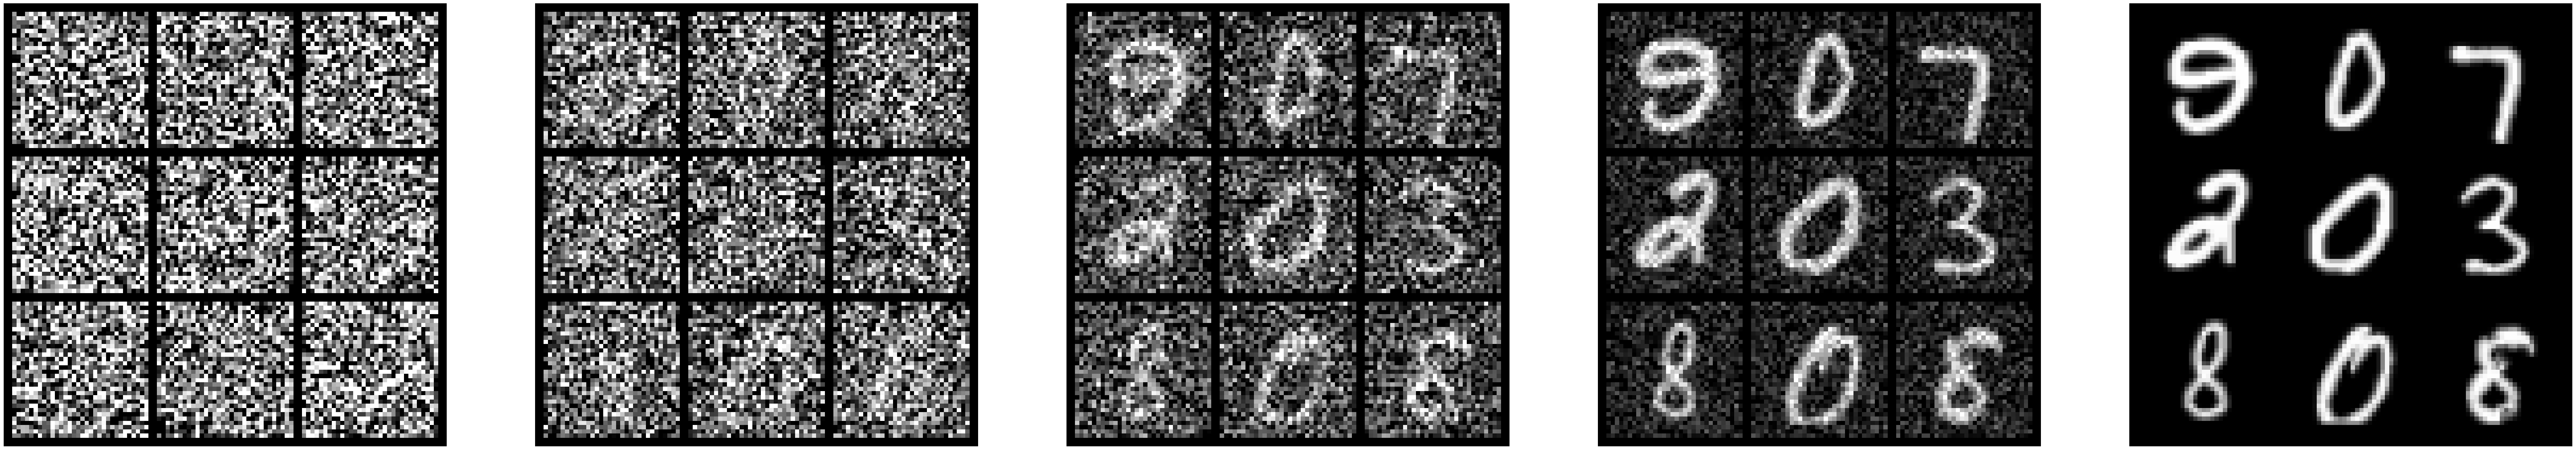

In [46]:
num_rows = 3
num_cols = 3
num_timesteps = 5

sampler = MNISTSampler().to(device)

path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape=[1,32,32],
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)

num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

fig, axes = plt.subplots(1, num_timesteps, figsize=(6*num_cols*num_timesteps, 6 * num_rows))

ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
  tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1)
  xt = path.sample_conditional_path(z, tt)
  grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
  axes[tidx].imshow(grid.permute(1,2,0).cpu(), cmap='gray')
  axes[tidx].axis('off')
plt.show()

## Part 2: Classifier Free Guidance

In [47]:
class ConditionalVectorField(nn.Module, ABC):
  @abstractmethod
  def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
    pass

class CFGVectorFieldODE(ODE):
  def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
    self.net = net
    self.guidance_scale = guidance_scale

  def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    guided_vector_field = self.net(x, t, y)
    unguided_y = torch.ones_like(y) * 10
    unguided_vector_field = self.net(x, t, unguided_y)

    return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field

In [48]:
class CFGTrainer(Trainer):
  def __init__(self, path: GaussianConditionalProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
    assert eta > 0 and eta < 1
    super().__init__(model, **kwargs)
    self.eta = eta
    self.path = path

  def get_train_loss(self, batch_size: int) -> torch.Tensor:
    z, y = self.path.p_data.sample(batch_size)

    xi = torch.rand(y.shape[0]).to(y.device)
    y[xi < self.eta] = 10.0

    t = torch.rand(batch_size, 1, 1, 1).to(z)
    x = self.path.sample_conditional_path(z, t)

    ut_theta = self.model(x, t, y)
    ut_ref = self.path.conditional_vector_field(x, z, t)
    error = torch.einsum('bchw -> b', torch.square(ut_theta - ut_ref))
    return torch.mean(error)

## Part 3: An architecture for images

In [74]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        # Converts (bs, y_embed_dim) -> (bs, channels)
        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed

        # Add y embedding (conditional embedding)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + y_embed

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Changed the input channels of the Conv2d layer to channels_in
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

In [79]:
class MNISTUNet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(nn.Conv2d(1, channels[0], kernel_size=3, padding=1), nn.BatchNorm2d(channels[0]), nn.SiLU())

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Initialize y embedder
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder(x, t_embed, y_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

In [82]:
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

trainer.train(num_epochs = 5, device=device, lr=1e-3, batch_size=1)

Training model with size: 2414.045 MiB


Epoch 4, loss: 1675.602: : 5it [00:00, 11.49it/s]
